# Can we accurately predict precipitation rates in London?

Section 004, Group 34: Aronn Grant Laurel Y., Mina Chen, Anabel Iris Eliora Hartanto, Farhan Ihsas Hoque

## Introduction

London is one of the world’s busiest cities, so rain can lead to significant disruptions in traffic. In this study, we will use a dataset by the European Climate Assessment (https://www.ecad.eu/dailydata/index.php) and predict precipitation rates in London using K-nearest neighbors regression. The dataset obtained covers daily weather measurements recorded by a London weather station with each row being daily observation from 1979-2020. 

The dataset contains 10 columns:

`date` : Measurement date - (int)

`cloud_cover` : Cloud cover - (oktas)

`sunshine` : Sunshine measurement (hrs)

`global_radiation` : Irradiance measurement  (W/m2)

`max_temp` : Maximum temperature(°C) 

`mean_temp` : Mean temperature (°C) 

`min_temp` : Minimum temperature (°C) 

`precipitation` : Precipitation (mm)

`pressure` : Pressure (Pa) 

`snow_depth` : Snow depth (cm)

We will be experimenting with all weather measurements to determine which factor has the best relationship with precipitation for the rain prediction.

## Preliminary exploratory data analysis

In [1]:
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
# Load libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(kknn)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

First, we use `read_csv()` to read the dataset, and `head` to read the first few rows of **weather_data**.

In [3]:
library(RCurl)
library(readr)
url <- "https://raw.githubusercontent.com/LaoAronn/ds_project/main/data/london_weather.csv"
weather_data <- read_csv(url)
head(weather_data)


Attaching package: ‘RCurl’


The following object is masked from ‘package:tidyr’:

    complete


Rows: 15341 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (10): date, cloud_cover, sunshine, global_radiation, max_temp, mean_temp...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


date     cloud_cover sunshine global_radiation max_temp mean_temp min_temp
1 19790101 2           7.0      52                2.3     -4.1      -7.5    
2 19790102 6           1.7      27                1.6     -2.6      -7.5    
3 19790103 5           0.0      13                1.3     -2.8      -7.2    
4 19790104 8           0.0      13               -0.3     -2.6      -6.5    
5 19790105 6           2.0      29                5.6     -0.8      -1.4    
6 19790106 5           3.8      39                8.3     -0.5      -6.6    
  precipitation pressure snow_depth
1 0.4           101900   9         
2 0.0           102530   8         
3 0.0           102050   4         
4 0.0           100840   2         
5 0.0           102250   1         
6 0.7           102780   1

Then, we use the `select()` function to limit the dataset to include only our weather predictors and the precipitation level. We will also use `na.omit()` function to remove all observations with any NA data and `rename` function to rename the columns for our Recipe to work.

In [43]:
# Using only data from 2010 to 2020
weather_year <- weather_data |>
                    mutate(year = round(date / 10000)) |>
                    filter(year >= 2010)


In [44]:
weather_filtered <- na.omit(weather_year)

weather_filtered <- weather_filtered |>
                        rename(cloud.cover = cloud_cover,
                               global.radiation = global_radiation,
                               mean.temp = mean_temp)
                        
weather_filtered <- weather_filtered |>
                        select(cloud.cover, sunshine, global.radiation, mean.temp, pressure, precipitation)

head(weather_filtered)

cloud.cover sunshine global.radiation mean.temp pressure precipitation
1 8           0.0      13               4.5       101600    1.5         
2 6           0.0      13               5.2       101780    0.0         
3 7           0.0      13               4.0       101690    0.0         
4 6           2.3      31               5.3       102030    0.0         
5 7           0.0      13               6.6       102150    0.5         
6 8           0.0      13               9.3       101850   12.2

Now, we will begin train the model by splitting **weather_data** into training and testing set with a proportion of 75% and 25% respectively. Since we are dealing with a time series data set, we will use `initial_time_split` function so it will take the first 75% data in the data frame instead of a randomized selection.

In [32]:
weather_split <- initial_time_split(weather_filtered, prop = 0.75, strata = precipitation)
weather_split

weather_training <- training(weather_split)

weather_testing <- testing(weather_split)

<Training/Testing/Total>
<2459/820/3279>

Using the training data, we create a table that displays the **correlation coefficient** between all factors with the Precipitation to find the strength of relationship between them.

In [33]:
# create matrix with 4 columns and 4 rows
data = matrix(c(cor(weather_training$precipitation, weather_training$cloud.cover),
                cor(weather_training$precipitation, weather_training$sunshine),
                cor(weather_training$precipitation, weather_training$global.radiation),
                cor(weather_training$precipitation, weather_training$mean.temp),
                cor(weather_training$precipitation, weather_training$pressure)
                ), ncol=5, byrow=TRUE)
 
# specify the column names and row names of matrix
colnames(data) = c('Cloud Cover','Sunshine','Global Radiation','Mean Temperature', 'Pressure')
rownames(data) <- c('Precipitation')
 
# assign to table
final_table = as.matrix(data)
 
# display
final_table

Cloud Cover Sunshine   Global Radiation Mean Temperature
Precipitation 0.2168178   -0.2227328 -0.1550186       -0.005725951    
              Pressure  
Precipitation -0.3251482

Furthermore, we will also plot graphs to compare the relationship between each selected weather factors and the precipitation levels.

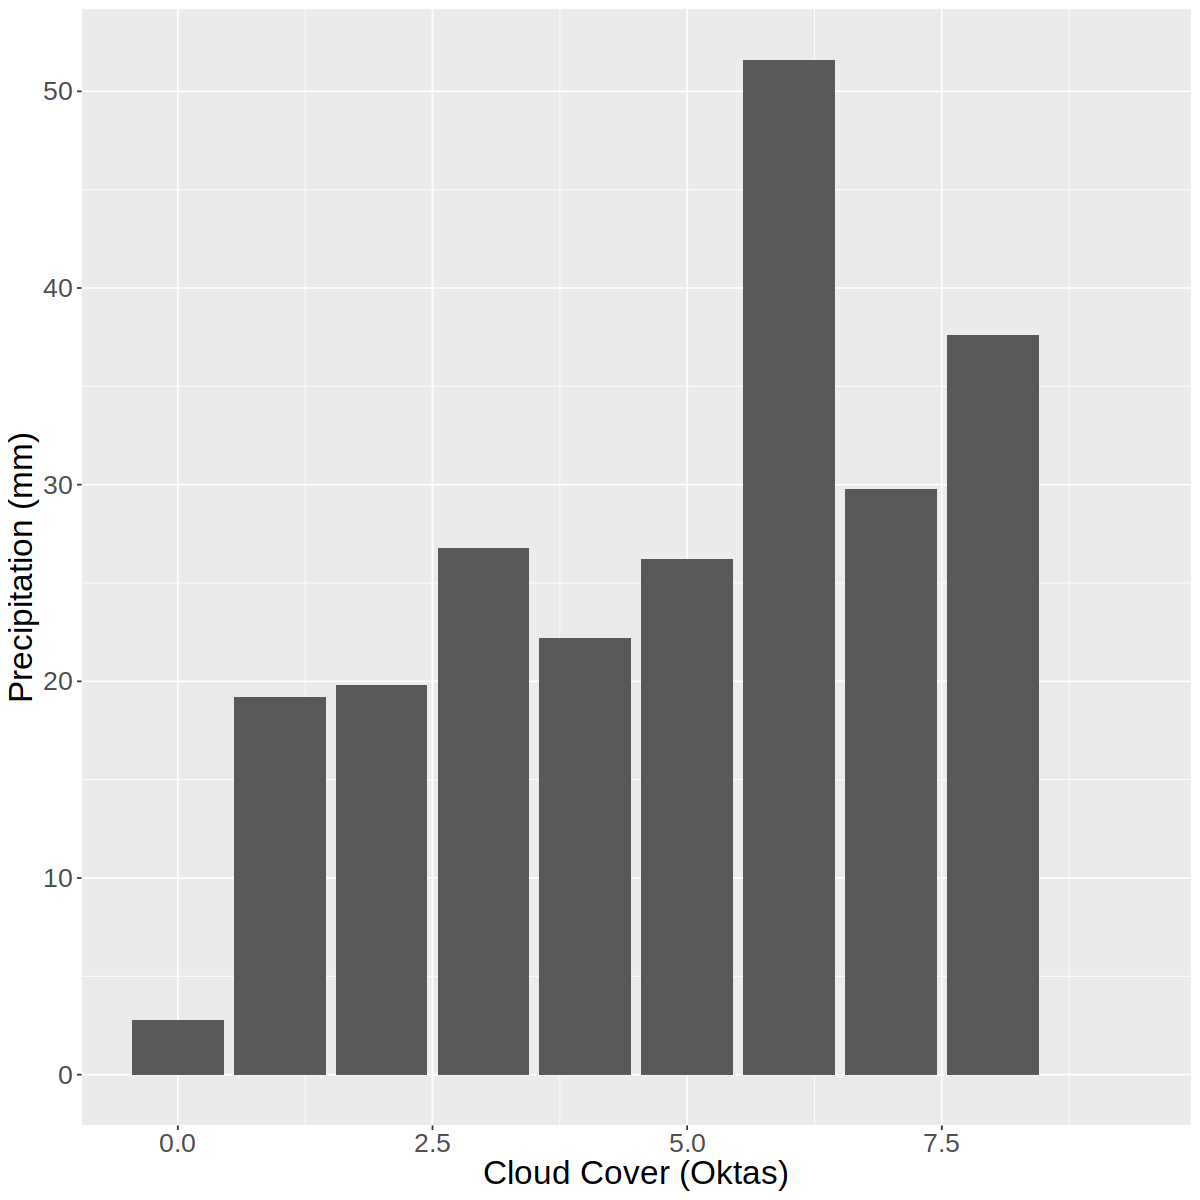

In [34]:
cloud_rain_plot <- weather_training |>
                    ggplot(aes(x = cloud.cover, y = precipitation) ) +
                    geom_bar(stat = "identity", position = "dodge") + 
                    labs(x = "Cloud Cover (Oktas)", y = "Precipitation (mm)") +
                    theme(text = element_text(size = 20))
cloud_rain_plot

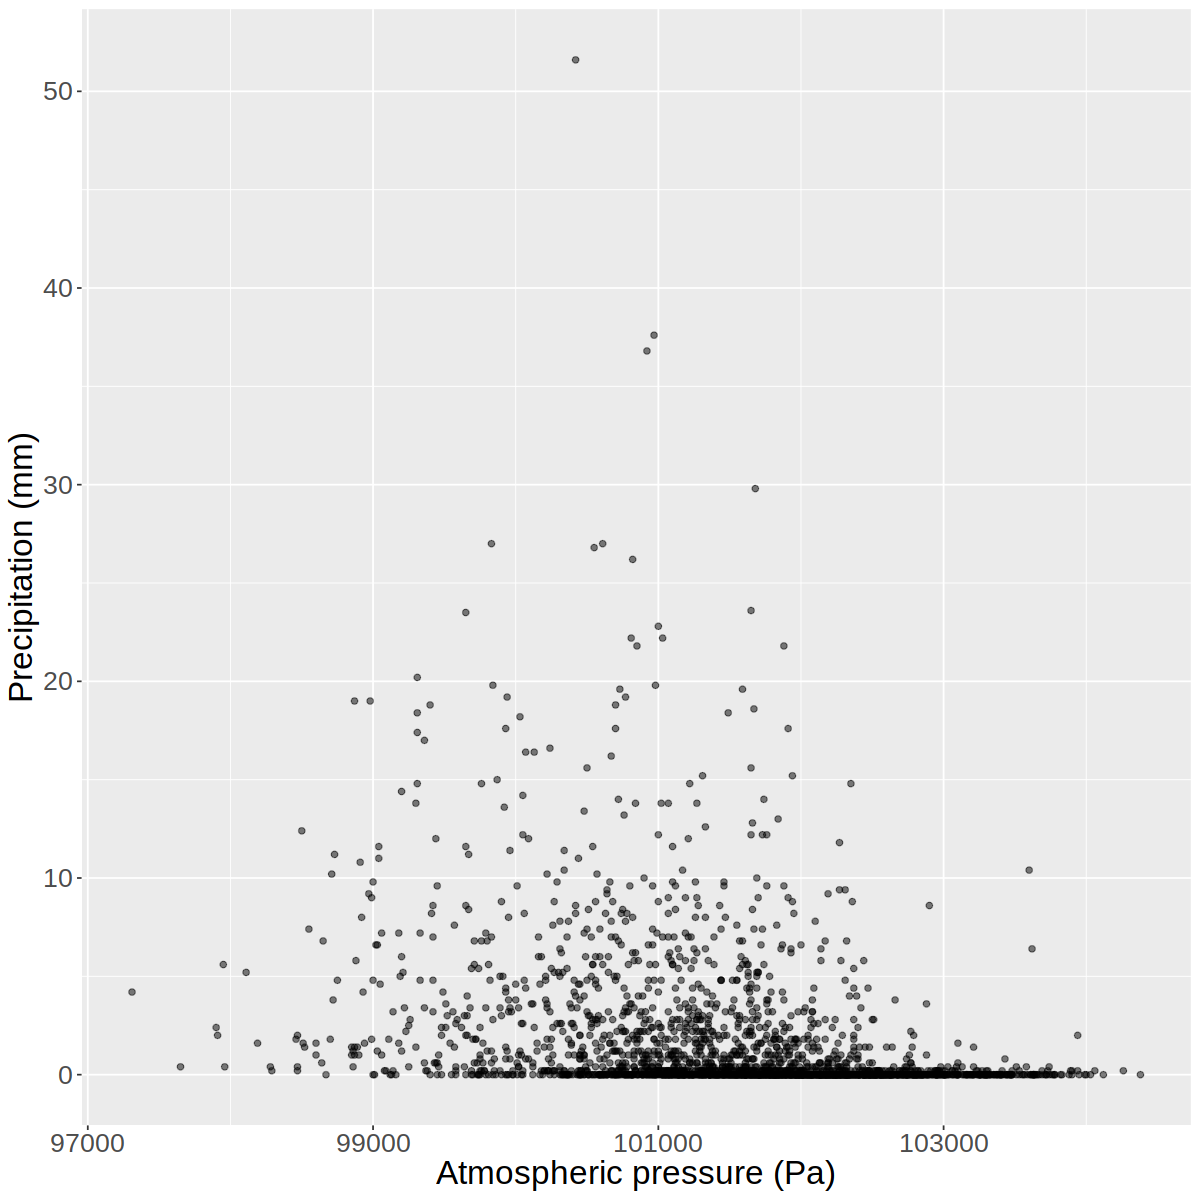

In [35]:
options(repr.plot.height = 10, repr.plot.width = 10)

pressure_rain_plot <- weather_training |>
                    ggplot( aes(x = pressure, y = precipitation) ) +
                    geom_point(alpha = 0.5) + 
                    labs(x = "Atmospheric pressure (Pa)", y = "Precipitation (mm)") +
                    theme(text = element_text(size = 20))
pressure_rain_plot

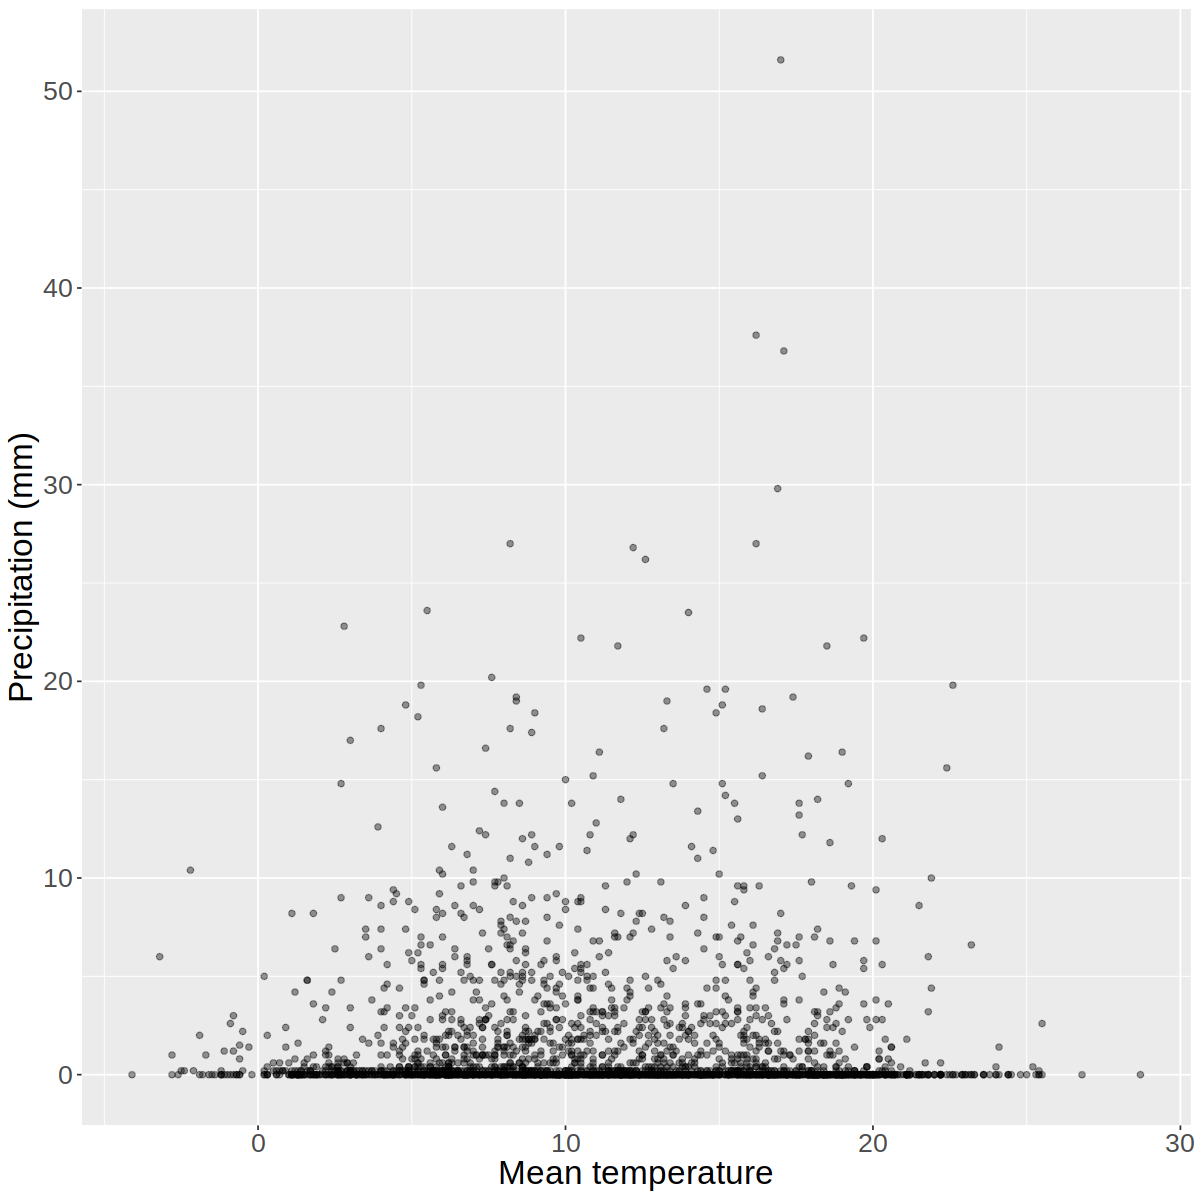

In [36]:
options(repr.plot.height = 10, repr.plot.width = 10)

temp_rain_plot <- weather_training |>
                    ggplot(aes(x = mean.temp, y = precipitation)) +
                    geom_point(alpha = 0.4) +
                    labs(x = "Mean temperature", y = "Precipitation (mm)") +
                    theme(text = element_text(size = 20))
temp_rain_plot

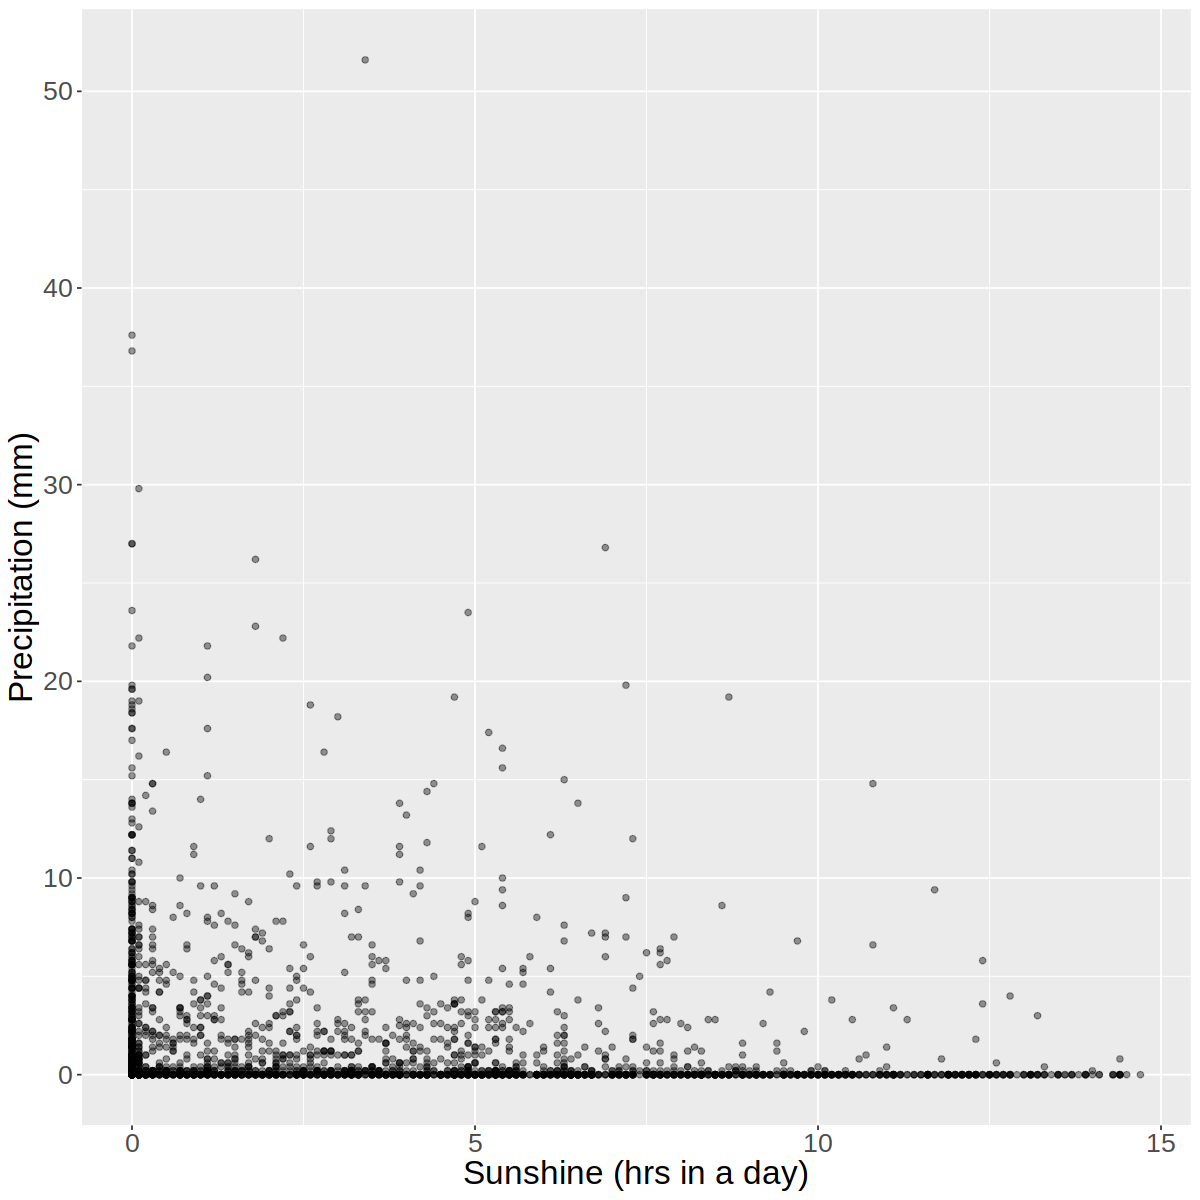

In [37]:
sun_rain_plot <- weather_training |>
                    ggplot( aes(x = sunshine, y = precipitation) ) +
                    geom_point(alpha = 0.4) + 
                    labs(x = "Sunshine (hrs in a day)", y = "Precipitation (mm)") +
                    theme(text = element_text(size = 20))
sun_rain_plot

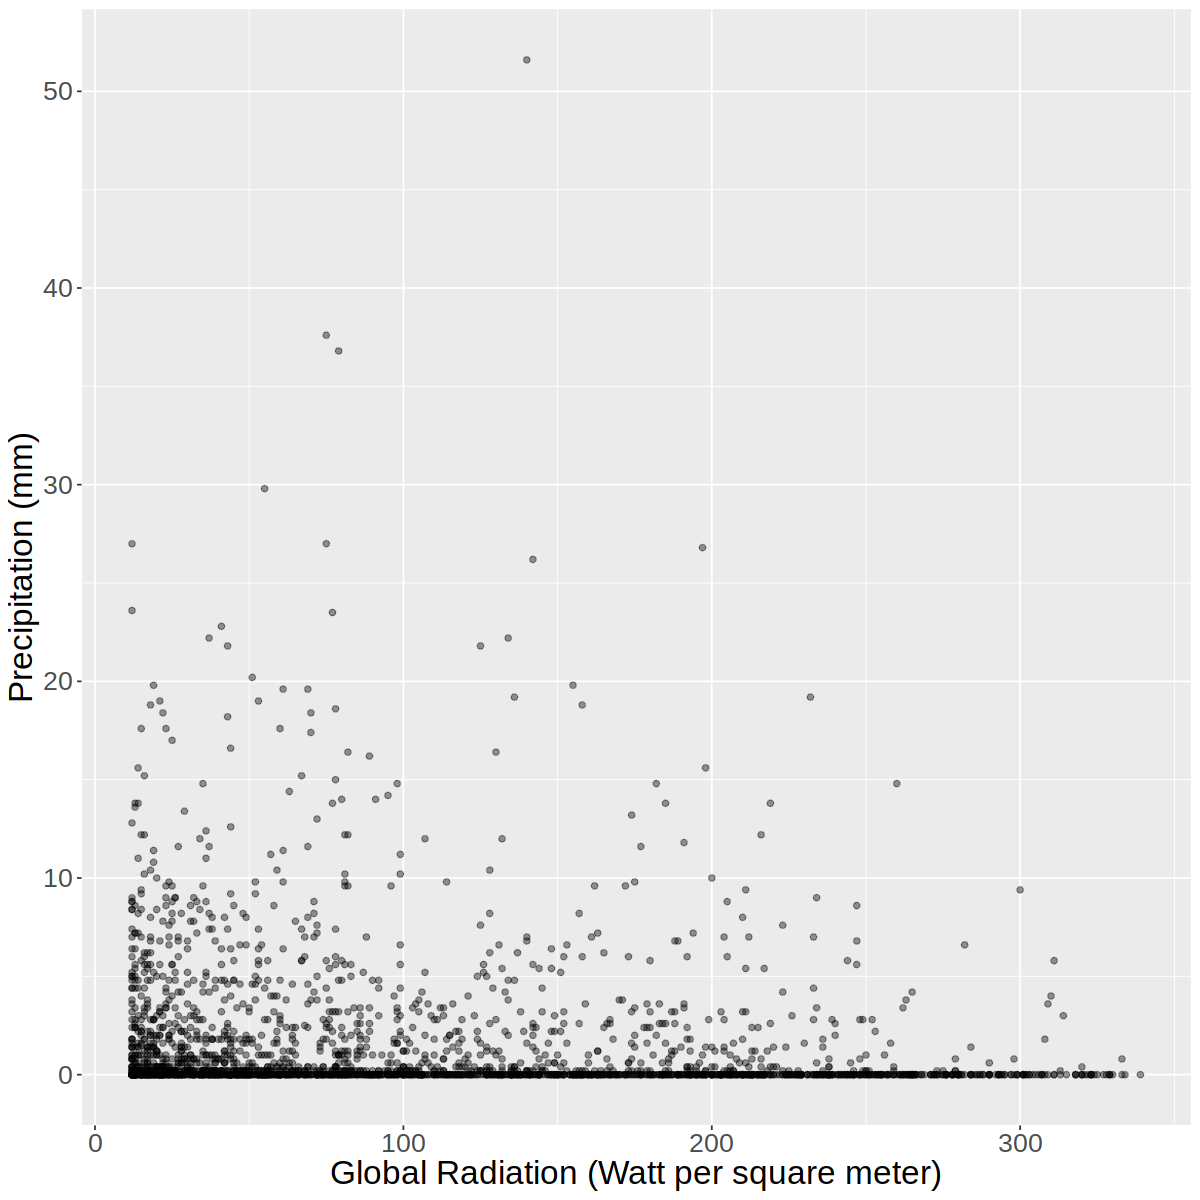

In [38]:
options(repr.plot.height = 10, repr.plot.width = 10)

radiation_rain_plot <- weather_training |>
                    ggplot( aes(x = global.radiation, y = precipitation) ) +
                    geom_point(alpha = 0.4) + 
                    labs(x = "Global Radiation (Watt per square meter)", y = "Precipitation (mm)") +
                    theme(text = element_text(size = 20))
radiation_rain_plot

### Findings from the plots
The plots above visualizes the relationship between the level of precipitation and each predictor in this analysis. 

- For `cloud_cover`, the plot shows an increasing trend between the precipitation and increasing cloud cover. 
- The scatter plot with `pressure` shows a negative relationship between atmospheric pressure and precipitation. 
- The scatter plot with `mean_temp` alone does not allow us to conclude a correlation between average temperatures and precipitation levels.
- The scatter plot with `sunshine` shows a negative relationship between hours of sunshine and the levels of precipitation. 
- The scatter plot with `global_radiation` shows a negative relationship between global radiation measurements and the levels of precipitation. 



In [39]:
weather_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("regression")

In [40]:
weather_recipe <- recipe(precipitation ~ cloud.cover + sunshine + global.radiation + mean.temp + pressure, data = weather_training) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())

In [41]:
weather_vfold <- vfold_cv(weather_training, v=5, strata = precipitation)

weather_workflow <- workflow() |>
                add_recipe(weather_recipe) |>
                add_model(weather_spec)
weather_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [42]:
gridvals <- tibble(neighbors = seq(from = 1, to = 200, by = 3))

weather_results <- weather_workflow |>
  tune_grid(resamples = weather_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")


In [23]:


gridvals <- tibble(neighbors = seq(from = 1, to = 81, by = 10))

weather_results <- weather_workflow |>
                tune_grid(resamples = weather_vfold, grid = gridvals) |>
                collect_metrics()

ERROR: [1m[33mError[39m in `check_installs()`:[22m
[33m![39m Some package installs are required: 
[36m•[39m 'kknn', 'kknn'


In [1]:
pnorm(2.5)

[1] 0.9937903

In [4]:
pnorm(3.75)

[1] 0.9999116

# Methods

##  Explain how you will conduct either your data analysis and which variables/columns you will use.
Aside from date and snow depth, we will consider all other weather conditions which include cloud cover, sunshine, global radiation, mean temperature, precipitation and pressure.
 
We do not consider snow depth because there is insufficient correlation between snow depth and precipitation with only 140 outlier data points among ​15342 observations while there is no snow (snow depth = 0cm) for the rest. 

Based on the plots between precipitation and other weather factors, we will take global radiation into consideration as they display a strong relationship.

## Describe at least one way that you will visualize the results
To compare relationships between variables, we use scatter plots as a way to visualize the results as it is the most effective for quantitative variables. For our regression model, we will visualize the testing dataset in a scatter plot, allowing us to assess the model’s accuracy, as we compare actual data with predicted data. 


# Expected Outcomes and Significance

From our analysis, we expect to find that precipitation levels can be predicted dependent on other correlated measurements of weather factors. We specifically anticipate that higher levels of precipitation occur in specific weather conditions, such as lower mean temperature, reduced sunshine and radiation, increased cloud cover, and lower pressure measurements. 

This analysis of historical weather data in London would provide valuable insights into current weather forecasting systems. These findings would also be beneficial in providing a better understanding of environmental processes and the impact of global changes on London’s weather patterns.

This study may lead to several future questions:
Are there any new factors introduced that may be a major factor to predicting precipitation levels? 
Has there been any shifting in factors and model predictability due to global climate change? 
How accurate are current weather forecasting models, how can we improve them?